In [1]:
from sqlalchemy import create_engine, inspect

engine = create_engine('sqlite:///data/movie.sqlite')
insp = inspect(engine)
insp.get_table_names()

['IMDB', 'earning', 'genre']

In [2]:
from sqlalchemy import MetaData, Table

metadata = MetaData()
genre_table = Table("genre", metadata, autoload_with=engine)
print(repr(genre_table))

Table('genre', MetaData(), Column('Movie_id', TEXT(), table=<genre>), Column('genre', TEXT(), table=<genre>), schema=None)


In [6]:
from sqlalchemy import text

with engine.connect() as con:
    stmt = text("select * from genre")
    res = con.execute(stmt).fetchmany(10)
    print(res)

[('36809', 'Biography'), ('30114', 'Adventure'), ('37367', 'Comedy'), ('49473', 'Comedy'), ('14867', 'Drama'), ('33832', 'Action'), ('31722', 'Drama'), ('25398', 'Drama'), ('10099', 'Animation'), ('25281', 'Comedy')]


In [7]:
from sqlalchemy import select

with engine.connect() as con:
    stmt = select(genre_table)
    res = con.execute(stmt).fetchmany(10)
    print(res)

[('36809', 'Biography'), ('30114', 'Adventure'), ('37367', 'Comedy'), ('49473', 'Comedy'), ('14867', 'Drama'), ('33832', 'Action'), ('31722', 'Drama'), ('25398', 'Drama'), ('10099', 'Animation'), ('25281', 'Comedy')]


In [10]:
earning_table = Table('earning', metadata, autoload_with=engine)
print(repr(earning_table))

Table('earning', MetaData(), Column('Movie_id', TEXT(), table=<earning>), Column('Domestic', INTEGER(), table=<earning>), Column('Worldwide', DOUBLE(), table=<earning>), schema=None)


In [13]:
with engine.connect() as con:
    stmt = select(earning_table).where(earning_table.columns.Worldwide > 1_000_000_000)
    res = con.execute(stmt).fetchmany(3)
    print(res)

[('49590', 408084349, 1153304495.0), ('44253', 532177324, 1056057273.0), ('47323', 304360277, 1108561013.0)]


In [16]:
from sqlalchemy import desc

with engine.connect() as con:
    stmt = select(earning_table.columns.Worldwide).order_by(desc(earning_table.columns.Worldwide))
    res = con.execute(stmt).fetchmany(3)
    print(res)

[(2068223624.0,), (1518812988.0,), (1153304495.0,)]


In [22]:
IMDB_table = Table('IMDB', metadata, autoload_with=engine)
for c in IMDB_table.columns:
    print(f"{c.name: <20}{c.type}")

Movie_id            TEXT
Title               TEXT
Rating              DECIMAL
TotalVotes          INTEGER
MetaCritic          DECIMAL
Budget              DOUBLE
Runtime             TEXT
CVotes10            TEXT
CVotes09            TEXT
CVotes08            TEXT
CVotes07            TEXT
CVotes06            TEXT
CVotes05            TEXT
CVotes04            TEXT
CVotes03            TEXT
CVotes02            TEXT
CVotes01            TEXT
CVotesMale          TEXT
CVotesFemale        TEXT
CVotesU18           TEXT
CVotesU18M          TEXT
CVotesU18F          TEXT
CVotes1829          TEXT
CVotes1829M         TEXT
CVotes1829F         TEXT
CVotes3044          TEXT
CVotes3044M         TEXT
CVotes3044F         TEXT
CVotes45A           TEXT
CVotes45AM          TEXT
CVotes45AF          TEXT
CVotes1000          TEXT
CVotesUS            TEXT
CVotesnUS           TEXT
VotesM              TEXT
VotesF              TEXT
VotesU18            TEXT
VotesU18M           TEXT
VotesU18F           TEXT
Votes1829     

In [35]:
from sqlalchemy import func

with engine.connect() as con:
    stmt = select(func.round(IMDB_table.columns.Rating).label('Rating'), IMDB_table.columns.Budget)
    rows = con.execute(stmt).fetchmany(5)
    for r in rows:
        print(f"{r.Rating} {r.Budget}")

8.0 20000000.0
8.0 18000000.0
8.0 8000000.0
8.0 12000000.0
8.0 8900000.0


In [46]:
with engine.connect() as con:
    stmt = select(
                func.round(IMDB_table.columns.Rating).label('Rating'),
                func.round(func.avg(IMDB_table.columns.Budget)).label("Budget"))\
            .group_by(func.round(IMDB_table.columns.Rating).label('Rating'))
    res = con.execute(stmt)
    for r in res.fetchall():
        print(f"{r.Rating} {r.Budget}")

8.0 71716666.67
9.0 109433333.33


          Budget    Rating
Budget  1.000000  0.210924
Rating  0.210924  1.000000


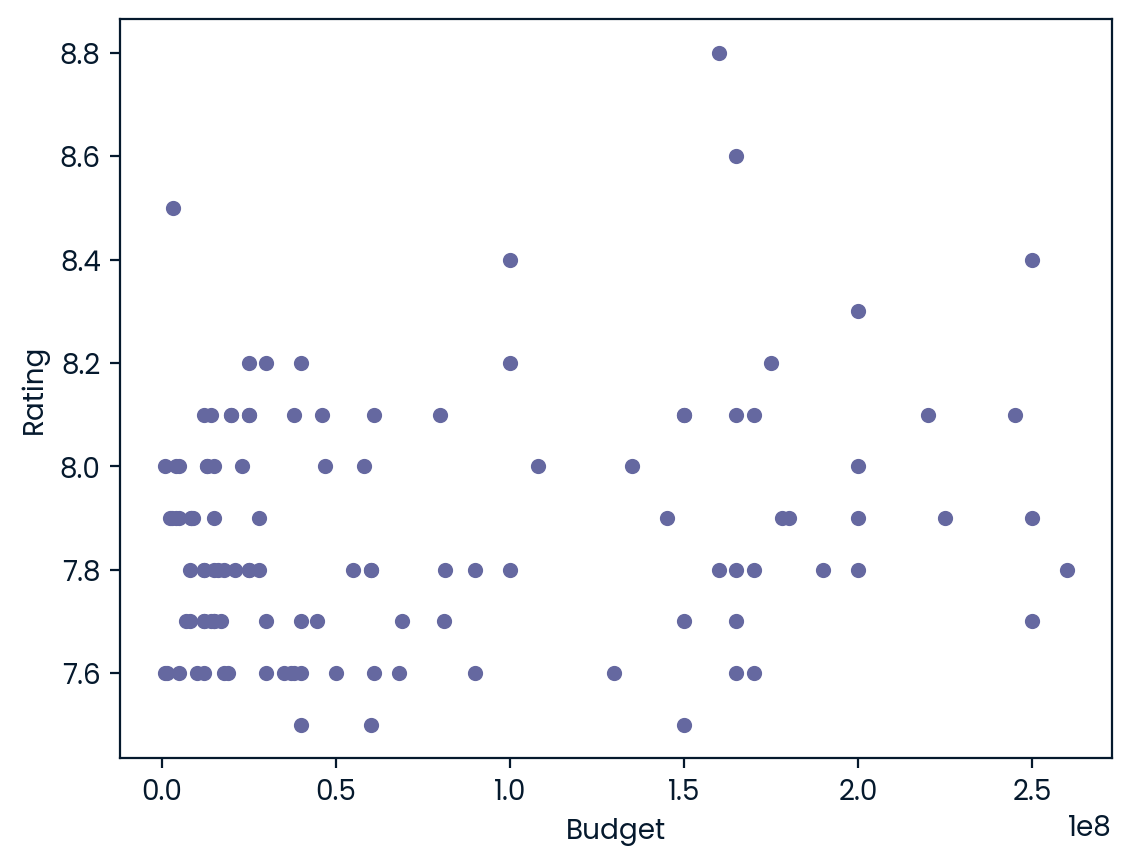

In [68]:
import pandas as pd

with engine.connect() as con:
    stmt = select(IMDB_table.columns.Rating, IMDB_table.columns.Budget)
    res = con.execute(stmt)
    df = pd.DataFrame(res.fetchall())
    df.columns = res.keys()
    df.replace('', pd.NA, inplace=True)
    df.dropna(inplace=True)
    df['Budget'] = df['Budget'].astype('float')
    df['Rating'] = df['Rating'].astype('float')
    print(df[['Budget', 'Rating']].corr())
    df.plot.scatter(x='Budget', y='Rating')
